In [1]:
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt 

from numpy.random import default_rng
rng = default_rng(seed=1234)

In [2]:
from masterthesis.data import load_h5ad

# load the python AnnData object
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/simdata.h5ad")
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/germ_sce.h5ad")
anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/acinar_sce.h5ad")
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/COVAC_POSTQC.h5ad")

# Preprocessing

In [3]:
from masterthesis.preprocessing import Preprocessing

# do not log transform
# do not normalize
# use all genes after filtering for low mean counts
pp = Preprocessing(log=False, normalize=True, select_genes="all")
anndata = pp.fit_transform(anndata)

In [4]:
from masterthesis.preprocessing import calculate_weights, transform_labels
from sklearn.model_selection import train_test_split

y = transform_labels(np.array([int(x) for x in anndata.obs.donor_age]))
X_train, X_test, y_train, y_test = train_test_split(anndata.X, y, 
                                                    test_size=0.1, 
                                                    stratify=y,
                                                    random_state=1234)

In [12]:
from masterthesis.model_selection import RegularizationGridSearch
from masterthesis.model import SGDBinarizedModel, LinearBinarizedModel
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer, log_loss

reg_params = np.geomspace(1, 100, 20)
#reg_params = np.geomspace(1, 0.001, 20)
weights_train = calculate_weights(y_train)
scoring = make_scorer(accuracy_score)
fit_params = {"sample_weight": weights_train}
estimator_params = None #{"max_iter": 20}

fit_params = {}
estimator_params = {}

lin = RegularizationGridSearch(estimator=LinearBinarizedModel, n_folds=5, n_jobs=1, lambdas=reg_params, scoring=scoring)
lin.fit(X_train, y_train, fit_params=fit_params, estimator_params=estimator_params)

Best idx: 5 Best Score: 0.6528693076638282 Best Lambda: 3.3598182862837818 Scores std: 0.15945405625766554
1SE idx: 5 1SE Score: 0.6528693076638282 1SE Lambda: 3.3598182862837818


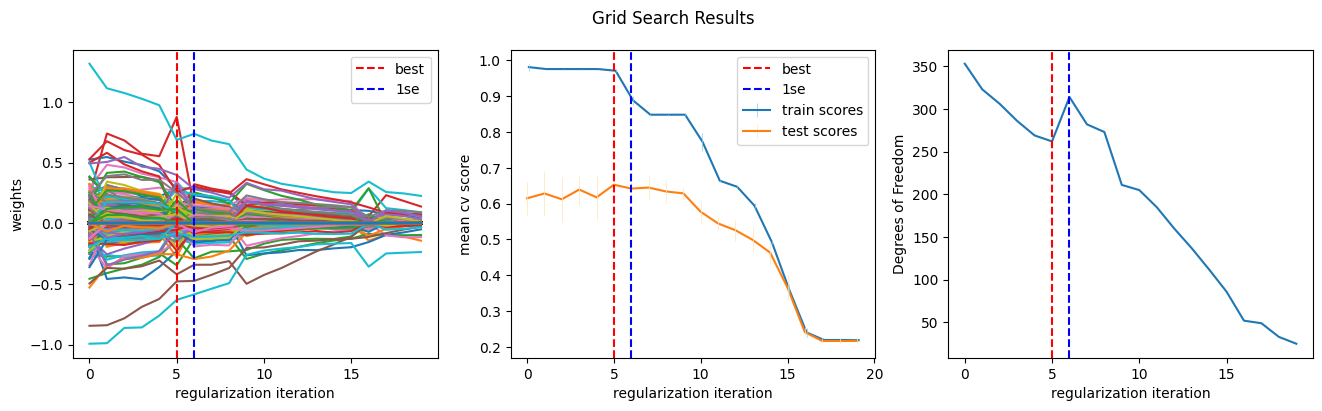

In [13]:
from masterthesis.plots import plot_grid_search
_ = plot_grid_search(lin)

In [8]:
sparse_model = lin.get_optimal_model("1se")
sparse_model.fit(X_train, y_train)

LinearBinarizedModel(regularization=10.0)

In [9]:
from masterthesis.model import BaseModel
import seaborn as sns
from matplotlib import pyplot as plt

def plot_model_perf(model, train, test, title="Model Predictions"):

    if not isinstance(model, BaseModel):
        raise ValueError("The first argument needs to be a fitted sklearn model")
    
    if not model.is_fitted_:
        raise ValueError("The grid_search must be run first! Did you call the `.fit()` method?")
    
    if not isinstance(train, tuple) or not isinstance(test, tuple):
        raise ValueError("The parameters `train`, `test` are expected to be tuples of np.array")

    X_test, y_test = test
    X_train, y_train = train
    labels = np.unique(np.concatenate([y_test, y_train]))
    y_test_trans = transform_labels(y_test, labels=labels)
    y_train_trans = transform_labels(y_train, labels=labels)
    
    weights_train = calculate_weights(y_train_trans)
    weights_test = calculate_weights(y_test_trans)

    print("Degrees of freedom", len(np.nonzero(model.coef_)[0]))
    print("Train:")
    print("Accuracy:", metrics.accuracy_score(y_train_trans, model.predict(X_train)))
    print("Balanced accuracy:", metrics.balanced_accuracy_score(y_train_trans, model.predict(X_train)))
    print("Mean absolute delta:", metrics.mean_absolute_error(y_train_trans, model.predict(X_train), sample_weight=weights_train))
    print("Test:")
    print("Accuracy:", metrics.accuracy_score(y_test_trans, model.predict(X_test)))
    print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_trans, model.predict(X_test)))
    print("Mean absolute delta:", metrics.mean_absolute_error(y_test_trans, model.predict(X_test), sample_weight=weights_test))

    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    sns.heatmap(metrics.confusion_matrix(y_test_trans, model.predict(X_test)), annot=True, ax=ax1)
    sns.heatmap(metrics.confusion_matrix(y_train_trans, model.predict(X_train)), annot=True, ax=ax2)

    ax1.set_xlabel("Test-Split Preditions")
    ax1.set_ylabel("Ground Truth Labels")
    ax2.set_xlabel("Train-Split Predictions")

    fig.suptitle(title)

    return fig


Degrees of freedom 251
Train:
Accuracy: 0.8482384823848238
Balanced accuracy: 0.625
Mean absolute delta: 0.05583996558399655
Test:
Accuracy: 0.6666666666666666
Balanced accuracy: 0.4591720779220779
Mean absolute delta: 0.37162162162162155


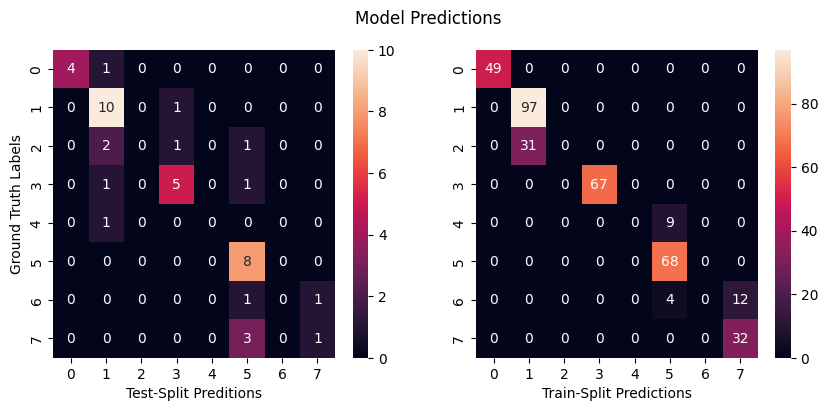

In [10]:
_ = plot_model_perf(sparse_model, test=(X_test, y_test), train=(X_train, y_train))